# Summarization Using Deep Learning Prototype

This notebook is a "first stab" at trying to use deep learning for automatic extractive text summarization. To simplify the problem I have made the following assumptions. 

- The input article is 20 sentences or less.
- A labeled dataset will be created by choosing up to the top 3 sentences that maximize the rouge score.
- The training task is to then automatically chose which sentences should be included in the summary. 
- The input is a list of sentences in the article, and 1 sentence from the article.
- The output is whether that sentence should be included in the summary or not. (1 or 0).
- To classify the entire document we will have to loop over each sentence to ask the model if it should be included or not. 

The structure for this model gets lots of ideas from this paper:

_SummaRuNNer: A Recurrent Neural Network based Sequence Model for
Extractive Summarization of Documents_

Ramesh Nallapati, Feifei Zhai, Bowen Zhou

https://arxiv.org/pdf/1611.04230.pdf


I have already made a clean dataset in the data cleaning notebook. So I can go ahead and load it. 

#### TODO
- Reprocess data with spacy and multiprocessing to reduce dependencies to spark (Hard to get tfrecords to work with pyspark 2.4 but spark nlp does not work with pyspark 3.0)
- Use given training/validation/test sets instead of own 

In [ ]:
# run the following command if you don't have the spacy model downloaded yet.
# This must be done before you import spacy. https://spacy.io/models/en#en_core_web_sm
# ! python -m spacy download en_core_web_sm

In [2]:
import pyspark
import pyspark.sql.functions as F
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import *
import spacy
import tensorflow_datasets as tfds
import pandas as pd

In [3]:
#Params

article_train_limit = None # How many articles we allow to be trained.
max_article_length = 30
batch = 128
fine_tune_USE = True # Whether or not our we should allow additional training on the sentence embedder.

In [4]:
# TODO: get rid of Spark since it is not really needed for this use case. 

spark = pyspark.sql.SparkSession.builder \
            .appName("Data Ingest") \
            .master("local[*]") \
            .config("spark.driver.memory", "16G") \
            .config("spark.driver.maxResultSize", "20G").getOrCreate()

In [5]:
df=spark.read.parquet('labeled.parquet')
df

DataFrame[article: string, highlights: string, id: bigint, sents: array<string>, labels: array<int>]

Here is a description of the columms

- **article** the original article.
- **highlights** the summary from the dataset. 
- **id** ID generated when processing the dataset for this project. 
- **sents** an array with the article split into individual sentences
- **labels** array same length as `sents` identifying which sentences should be in the summary.

In [6]:
df = df.withColumn("sent_count", F.size(df.sents))
df = df.where(df.sent_count<=max_article_length).toPandas()

# If the article is less than max_article_length, we need to pad and mask the empty sentences.
def make_mask(sents):
    length = len(sents)
    return ([True] * length) +([False] * (max_article_length-length))

# Just use empty strings to pad
def pad_sents(sents):
    length = len(sents)
    return sents + [""] * (max_article_length-length)

small_df = df.iloc[0:article_train_limit].copy()
small_df['mask'] = small_df.sents.map(make_mask)

# Here we pair the label and individual sentence then explode these into individual training examples.
small_df['paired'] = small_df.apply(lambda x: list(zip(x.labels, x.sents)), axis=1)
small_df = small_df.explode('paired')
small_df['label'] = small_df.paired.map(lambda x: x[0])
small_df['sent'] = small_df.paired.map(lambda x: x[1])
small_df['sents'] = small_df.sents.map(pad_sents)
small_df = small_df[['id', 'sents', 'sent', 'label', 'mask']]
small_df.shape

(3094744, 5)

In [7]:
positive = small_df[small_df.label==1].shape[0]
balanced = small_df[small_df.label==0].iloc[0:positive].copy()
balanced = balanced.append(small_df[small_df.label==1].copy())
small_df = balanced.sample(frac=1)
small_df.shape

(907826, 5)

Here is the description of the transformed columns

- **id** Same as before, now duplicated as many times as there are number of sentences.
- **sents** The sentences parsed out, also duplicated within the dataframe. 
- **sent** The individual sentence for the training example
- **label** Whether or not this example should be included in the summary
- **mask** To keep track of which sentences are just padding

## Model Graph

Below you can see the summary and image. 
For the forward pass we have the sentences that get embedded using Universal Sentence Encoder and then squashed into 1 vector using a GRU. 
Then the sentence to be classified is embedded using Universal Sentence encoder as well. 
These two vectors are concatenated and dense layers bring it down to 1 output. 

In [8]:
# This can take a minute to load.
# Loading this one multiple times sometimes causes errors. 
# If running the cells below multiple times and you get some weird un explainable error, restart
# the kernel to see if it helps. 

#If you get the error SavedModel file does not exist at: /var/folders/cl....
# Delete it ex: rm -r /var/folders/cl/63p3pg596jq18sjxn0zdb8k40000gn/T/tfhub_modules/063d866c06683311b44b4992fd46003be952409c

use_embed_sent = hub.keras_layer.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", name="sent_embedder", trainable=fine_tune_USE)
use_embed_article_sentences = hub.keras_layer.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4", name="article_sents_embedder", trainable=fine_tune_USE)

In [9]:
article_sentences = tf.keras.layers.Input(shape=[max_article_length],dtype=tf.string, name="article_sentences", ragged=False)
sent = tf.keras.layers.Input(shape=[], name='sent', dtype=tf.string)
mask = tf.keras.layers.Input(shape=[max_article_length], dtype=tf.bool, name="mask")
sent_reshaped = tf.reshape(sent, [-1], name="sent_reshaped")
sent_embed = use_embed_sent(sent_reshaped)
sent_embed_reshaped = tf.reshape(sent_embed, [-1,512], name="sent_embed_reshaped")
article_sentences_1d = tf.reshape(article_sentences, [-1], name="article_sentences_1d")
article_sentences_embed = use_embed_article_sentences(article_sentences_1d)
article_sentences_restored = tf.reshape(article_sentences_embed, [-1, max_article_length, 512], name="article_sentences_restored")
article_sentences_gru = tf.keras.layers.GRU(512,name="gru")(article_sentences_restored, mask=mask)
concatenated = tf.concat([article_sentences_gru, sent_embed_reshaped], axis=1, name="concated")
d1 = layers.Dense(128, activation='relu')(concatenated)
d2 = layers.Dense(1, activation='sigmoid')(d1)
model = Model(inputs=[article_sentences, sent, mask], outputs=[d2])
model.compile(loss=losses.BinaryCrossentropy(), metrics=['accuracy', tf.keras.metrics.Recall()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
article_sentences (InputLayer)  [(None, 30)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_article_sentences_1 [(None,)]            0           article_sentences[0][0]          
__________________________________________________________________________________________________
sent (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
article_sents_embedder (KerasLa (None, 512)          256797824   tf_op_layer_article_sentences_1d[
______________________________________________________________________________________________

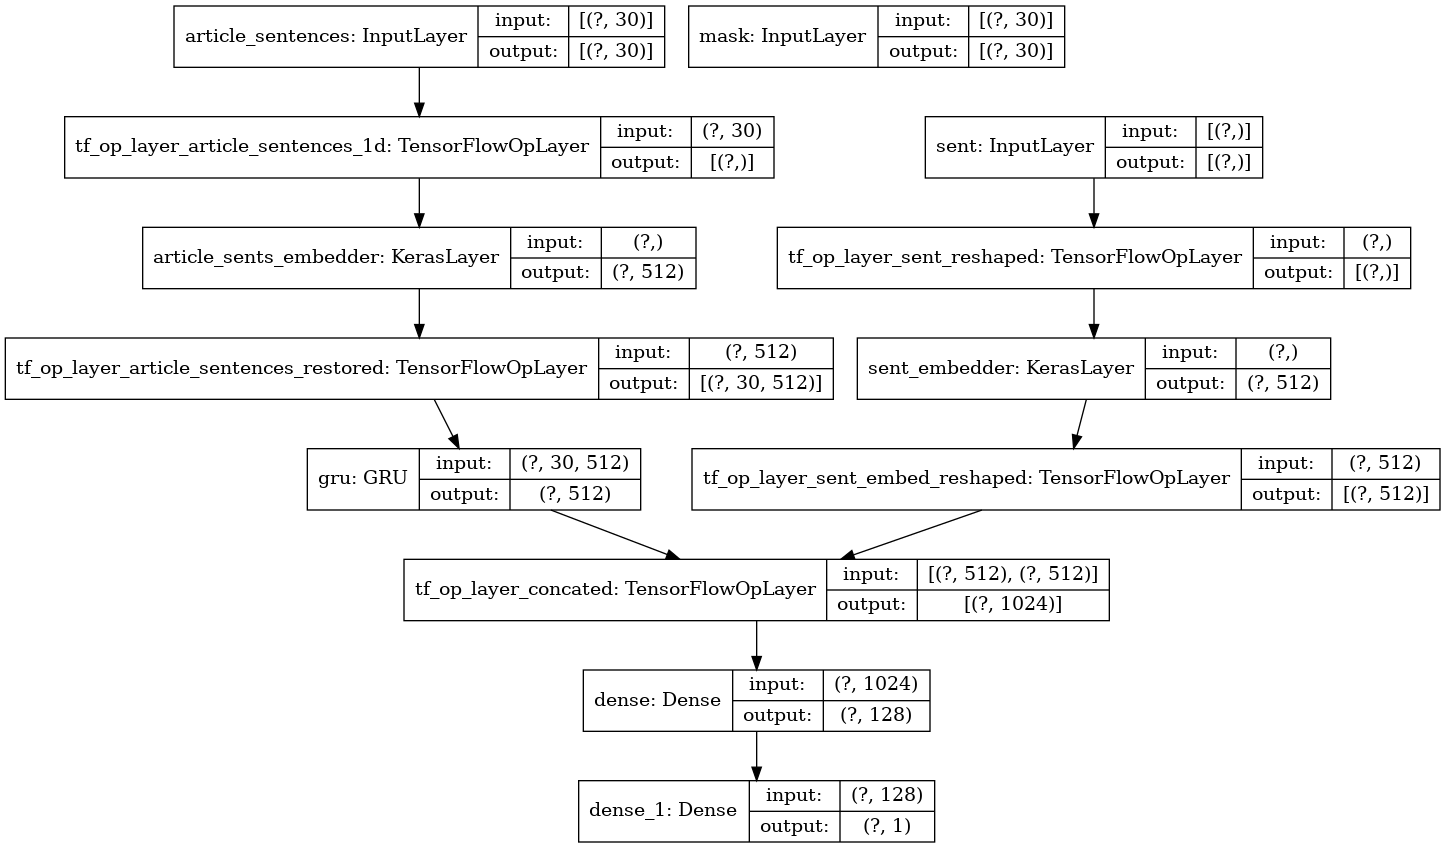

In [10]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
checkpoint_filepath = 'tfmodel'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [12]:
history = model.fit(x={"article_sentences":tf.constant(small_df.sents.values.tolist()), 
             "sent":tf.constant(small_df.sent.values.tolist()), 
             "mask": tf.constant(small_df['mask'].values.tolist())}, 
          y=tf.convert_to_tensor(small_df.label.values), 
          batch_size=batch, 
          validation_split=0.2, epochs=5,callbacks=[model_checkpoint_callback])

Epoch 1/5
5674/5674 [==============================] - ETA: 0s - loss: 0.3695 - accuracy: 0.8301 - recall: 0.8206WARNING:tensorflow:From /home/jzeimen/anaconda3/envs/p36/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: tfmodel/assets


INFO:tensorflow:Assets written to: tfmodel/assets


5674/5674 [==============================] - 6063s 1s/step - loss: 0.3695 - accuracy: 0.8301 - recall: 0.8206 - val_loss: 0.2483 - val_accuracy: 0.8992 - val_recall: 0.8354
Epoch 2/5
5674/5674 [==============================] - ETA: 0s - loss: 0.2144 - accuracy: 0.9150 - recall: 0.8637INFO:tensorflow:Assets written to: tfmodel/assets


INFO:tensorflow:Assets written to: tfmodel/assets


5674/5674 [==============================] - 6055s 1s/step - loss: 0.2144 - accuracy: 0.9150 - recall: 0.8637 - val_loss: 0.2354 - val_accuracy: 0.9056 - val_recall: 0.8202
Epoch 3/5
5674/5674 [==============================] - ETA: 0s - loss: 0.2072 - accuracy: 0.9201 - recall: 0.8667INFO:tensorflow:Assets written to: tfmodel/assets


INFO:tensorflow:Assets written to: tfmodel/assets


5674/5674 [==============================] - 6045s 1s/step - loss: 0.2072 - accuracy: 0.9201 - recall: 0.8667 - val_loss: 0.2317 - val_accuracy: 0.9083 - val_recall: 0.8260
Epoch 4/5
5674/5674 [==============================] - ETA: 0s - loss: 0.2018 - accuracy: 0.9235 - recall: 0.8734INFO:tensorflow:Assets written to: tfmodel/assets


INFO:tensorflow:Assets written to: tfmodel/assets


5674/5674 [==============================] - 6053s 1s/step - loss: 0.2018 - accuracy: 0.9235 - recall: 0.8734 - val_loss: 0.2277 - val_accuracy: 0.9105 - val_recall: 0.8430
Epoch 5/5
5674/5674 [==============================] - 6025s 1s/step - loss: 0.1844 - accuracy: 0.9316 - recall: 0.8885 - val_loss: 0.2424 - val_accuracy: 0.8982 - val_recall: 0.8688


# Predict

In [26]:
validation_articles = [i for i in tfds.load("cnn_dailymail")['validation']]

In [27]:
print("Choose an article number betwen 0 and " + str(len(validation_articles)))

Choose an article number betwen 0 and 13368


In [28]:
# TODO this might be data leakage because I processed all the records before so training may have seen these records. 
article_to_test = 60

In [29]:
article = validation_articles[article_to_test]['article'].numpy().decode()
summary = validation_articles[article_to_test]['highlights'].numpy().decode()

In [30]:
# See info here https://spacy.io/models/en#en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [31]:
sentences = list(nlp(article, disable=['tagger', 'ner']).sents)
len(sentences)

23

In [32]:
summary

"I Quit Sugar author Sarah Wilson has said too many 'wellness warriors' are not taking responsibility for their actions .\nHer words come in the wake of intense criticism of Whole Pantry founder Belle Gibson .\nDoubts have been raised over Ms Gibson's terminal cancer claims and charitable donations .\nMs Wilson said:\xa0'There's a lot of people out there not taking on board the responsibility that comes with this'\nMs Gibson  told Daily Mail Australia she would issue an explanatory statement last week - but she hasn't issued an explanation ."

In [33]:
article

"Wellness guru Sarah Wilson has weighed in on the Belle Gibson controversy, saying too many health bloggers do not understand their power and responsibility. Ms Gibson, founder of the popular Whole Pantry app, has faced intense criticism since doubts were raised about whether she has terminal cancer. Ms Wilson, author of I Quit Sugar, told Daily Mail Australia that the incident was 'unfortunate' and that health bloggers have a huge responsibility to their followers. 'The real issue that's going on is there's a lot of people out there not taking on board the responsibility that comes with all this,' she said. Scroll down for video . I Quit Sugar author Sarah Wilson told Daily Mail Australia many bloggers are 'not taking on board the responsibility' that comes with publishing . Whole Pantry founder Belle Gibson last week said she would issue an explanatory statement, but it has not materialised . 'I don't know that you need to be a dietitian to share information about your health journey

In [34]:
def predict(article):
    sentences = [str(i) for i in nlp(article, disable=['tagger', 'ner']).sents]
    sentences = sentences[:max_article_length]
    original_length = len(sentences)
    sentences = pad_sents(sentences)
    mask = make_mask(sentences)
    scores = model({"article_sentences":tf.constant([sentences]*max_article_length), 
             "sent":tf.constant(sentences), 
             "mask": tf.constant([mask]*max_article_length)})
    scores = scores.numpy().squeeze()
    return scores, sentences
    

In [35]:
score, sents = predict(article)

In [36]:
pd.set_option('display.max_colwidth', None)
df = pd.DataFrame({'score': score, 'sentence': sents})
df.style.background_gradient(cmap ='Blues', axis=0)

,score,sentence
0,0.896164,"Wellness guru Sarah Wilson has weighed in on the Belle Gibson controversy, saying too many health bloggers do not understand their power and responsibility."
1,0.741450,"Ms Gibson, founder of the popular Whole Pantry app, has faced intense criticism since doubts were raised about whether she has terminal cancer."
2,0.838635,"Ms Wilson, author of I Quit Sugar, told Daily Mail Australia that the incident was 'unfortunate' and that health bloggers have a huge responsibility to their followers. '"
3,0.876278,"The real issue that's going on is there's a lot of people out there not taking on board the responsibility that comes with all this,' she said."
4,0.347169,Scroll down for video .
5,0.347169,I Quit Sugar author Sarah Wilson told Daily Mail Australia many bloggers are 'not taking on board the responsibility' that comes with publishing .
6,0.406235,"Whole Pantry founder Belle Gibson last week said she would issue an explanatory statement, but it has not materialised . '"
7,0.347168,I don't know that you need to be a dietitian to share information about your health journey. '
8,0.347169,If you are somebody who works online
9,0.735905,and you claim to be a (health) blogger you have to take on certain responsibilities. '


In [24]:
df.nlargest(3,'score').sort_index()

,score,sentence
12,0.969950,There's a lot of people out there who are't taking on the responsibility of being a disseminator of information. '
15,0.961230,"Ms Gibson has stayed mum about her health since admitting in an interview with The Australian that her previous claims cancer had spread to her blood, spleen, uterus and liver may have been a 'misdiagnosis'."
16,0.955846,"In the weeks since doubts were raised about Belle Gibson's cancer and charitable donations, her US and Australian publishers have withdrawn support for her recipe books ."


In [25]:
summary

"I Quit Sugar author Sarah Wilson has said too many 'wellness warriors' are not taking responsibility for their actions .\nHer words come in the wake of intense criticism of Whole Pantry founder Belle Gibson .\nDoubts have been raised over Ms Gibson's terminal cancer claims and charitable donations .\nMs Wilson said:\xa0'There's a lot of people out there not taking on board the responsibility that comes with this'\nMs Gibson  told Daily Mail Australia she would issue an explanatory statement last week - but she hasn't issued an explanation ."